### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).



In [254]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [255]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


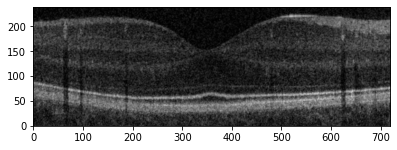

In [256]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
original_image = image

In [257]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)

    def update_curve(self):
        self.p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        self.p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        self.p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([self.p0, self.p1,self.p2]))



In [258]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [259]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [260]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

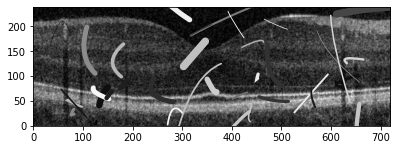

In [261]:
# Initialise clew of 40 and draw

clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

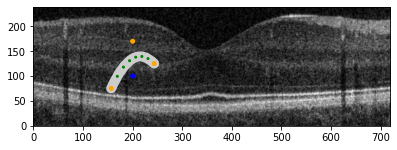

In [262]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

&copy; Cara MacNish, UWA, 2024



# ------------------------------------------------------------------------------

# Distance between worms

In [263]:
import matplotlib.colors as mcolors

In [264]:
# Initialise clew
clew = initialise_clew(3, image.shape, (40, 30, 1))

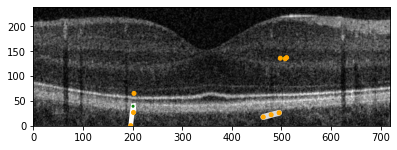

In [265]:
# Draw
drawing = Drawing(image)
drawing.add_worms(clew)
for worm in clew:
    drawing.add_dots(worm.intermediate_points(), radius=2, color='green')
    drawing.add_dots(worm.control_points(),color='orange')
drawing.show()

In [266]:
# Make list of intermediade points + extrema control points (not the middle point) for each worm
all_points = []
for i in range(len(clew)):
    all_points.append(list(np.vstack((clew[i].control_points()[0],clew[i].control_points()[2],clew[i].intermediate_points()))))

In [267]:
# matrix for shortest distances
D = np.zeros((len(clew),len(clew)))
# dict for points that have the shortest distance
shortest_distance = dict(zip(list(np.arange(len(clew))),[ [] for _ in range(len(clew)) ]))

# loop through all worms (but the last)
for m in range(len(clew)-1):
    # loop throug all remaining worms
    for n in range(m+1,len(clew)):
        dist = 100000
        # loop through all points in worm m
        for i in all_points[m]:
            # loop through all points in worm n
            for j in all_points[n]:
                dist_temp = np.linalg.norm(i-j) # calculate eucledian distance
                if dist_temp < dist:
                    dist = dist_temp # update distance variable if this distance is shorter

                    D[m][n] = dist # append shortest distance to matrix
                    p = (i,j) # save the two points
                
        shortest_distance[m].append(p) # append the points to dict

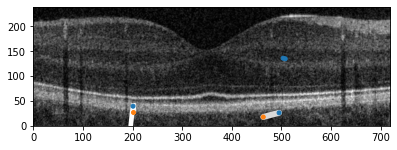

In [268]:
# draw the points
colors = list(mcolors.TABLEAU_COLORS.keys())
drawing = Drawing(image)
drawing.add_worms(clew)
for i in range(len(shortest_distance)):
    for j in range(len(shortest_distance[i])):
        drawing.add_dots((shortest_distance[i][j][0],shortest_distance[i][j][1]),color=colors[i])

drawing.show()

## Make circular mask and find image intensity

In [269]:
clew = initialise_clew(10, image.shape, (40, 30, 1))

In [270]:
### The following function is inspired by answers given on this page:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array

def circular_mask(image,center,radius):
    # get image dimensions
    h = image.shape[1]
    w = image.shape[0]

    # create matrix with same shape as image and elements being the distance from the center point
    Y, X = np.ogrid[:w, :h]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    # create mask. True in pixels that are closer than the radius to the center. False everywhere else
    mask = dist_from_center <= radius
    return mask

In [271]:

def mask_single_worm(masked_image, worm, key):
    for i in range(len(worm.intermediate_points())): # loop through intermediate points in worm
        mask = circular_mask(image,[worm.intermediate_points()[i][0],worm.intermediate_points()[i][1]],worm.width) # make circular mask
        masked_image[mask] = int(key) # classify points based on the worm it belongs to
    # plt.imshow(masked_img)
    # plt.gca().invert_yaxis()
    return masked_image

In [272]:
def mask_all_worms(image, clew):
    masked_img = np.zeros([image.shape[0],image.shape[1]]).astype(int)
    for i in range(len(clew)):
        masked_img = mask_single_worm(masked_img, clew[i], i + 1)
    # plt.imshow(masked_img)
    # plt.gca().invert_yaxis()
    return masked_img

In [273]:
masked_img = mask_all_worms(image, clew)

In [274]:


# def mask_all_worms(image, clew):
#     # create a masked image for clew
#     masked_img = np.zeros([image.shape[0],image.shape[1]]).astype(int)
#     # create a string to store mean intensity and standard variation for each worm
#     worm_intensities = []

#     for worm_index in range(len(clew)): # loop through worms in clew
#         worm = clew[worm_index]
#         masked_img_worm = np.zeros([image.shape[0],image.shape[1]]).astype(int) # initialize mask with zeros
#         for i in range(len(worm.intermediate_points())): # loop through intermediate points in worm
#             mask = circular_mask(image,[worm.intermediate_points()[i][0],worm.intermediate_points()[i][1]],worm.width) # make circular mask
#             masked_img[mask] = int(worm_index+1) # classify points based on the worm it belongs to
            
#         masked_img_worm = masked_img # mask for each worm
       
#         worm_intensities.append((np.mean(image * masked_img_worm), np.std((image * masked_img_worm)[(image * masked_img_worm)>0]))) # update values
            
#     clew_intensities = (np.mean(image * masked_img), np.std((image * masked_img)[(image * masked_img)>0]))

#     plt.imshow(masked_img)
#     plt.gca().invert_yaxis()
#     return masked_img
# masked_img = mask_all_worms(image, clew)

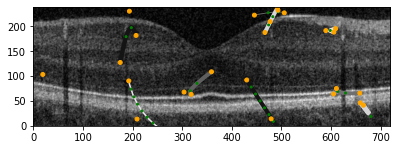

In [275]:
# Draw
drawing = Drawing(image)
drawing.add_worms(clew)
for worm in clew:
    drawing.add_dots(worm.intermediate_points(), radius=2, color='green')
    drawing.add_dots(worm.control_points(),color='orange')
drawing.show()

In [276]:
## ALTERNATIVELY

In [277]:
worm = random_worm(image.shape, (40, 30, 1))

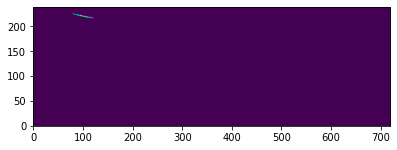

In [278]:
width, height=image.shape[0],image.shape[1]

poly_path=worm.path()

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
plt.imshow(mask.reshape(height, width).T)
plt.gca().invert_yaxis()

plt.show()


['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


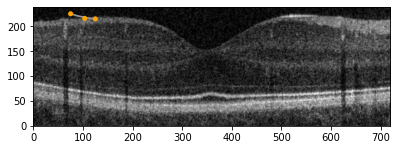

In [279]:
# draw the points
colors = list(mcolors.TABLEAU_COLORS.keys())
print(colors)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.control_points(),color='orange')

drawing.show()

# Basic Algorithm

In [280]:
import copy
class Camo_Worm_Solution:
    def __init__(self, target_image, weights, pop=40, name="unnamed_trial"):
        self.pop_size = pop
        self.weights = weights
        self.target_image = target_image
        (self.ylim, self.xlim) = target_image.shape
        self.name = name
        self.worm_pop = initialise_clew(pop, target_image.shape, (40, 30, 1))
        # Initialise a list of intermediate points for each worm
        self.all_points = []
        for worm in self.worm_pop:
            self.all_points.append(list(worm.intermediate_points()))
        # Initialise shortest distances and worm ids
        for i in range(self.pop_size):
            self.worm_pop[i].worm_id = i
            self.worm_pop[i].shortest_dist = self.calc_short_dist(i, self.worm_pop[i].intermediate_points())
    
    # this should work for both the old worm and the new candidate worm
    def calc_short_dist(self, worm_index, worm_points):
        dist = np.inf
        for n in list(range(worm_index)) + list(range(worm_index+1, self.pop_size)): # for all OTHER worms in pop
            # loop through all points in chosen worm
            for i in worm_points:
                #loop through all points in worm n
                for j in self.all_points[n]:
                    dist_temp = np.linalg.norm(i-j) # calculate euclidean distance
                    if dist_temp < dist:
                        dist = dist_temp # update distance variable if this distance is shorter
        return dist
    
    def calc_dist_cost(self, worm):
        return 1 / (worm.shortest_dist + worm.width)
    
    def calc_unweighted_costs(self, worm):
        worm.size = worm.approx_length() * worm.width
        worm.bend = worm.dr / worm.r
        worm.camo_cost = 0
        worm.dist_cost = self.calc_dist_cost(worm)
    
    def evolve_worm(self, worm):
        midx = worm.x + rng.standard_normal()
        if midx < 0:
            midx = 0
        elif midx > self.xlim:
            midx = self.xlim
        midy = worm.y + rng.standard_normal()
        if midy < 0:
            midy = 0
        elif midy > self.ylim:
            midy = self.ylim
        r = np.abs(worm.r + rng.standard_normal())
        theta = worm.theta + rng.standard_normal()
        dr = np.abs(worm.dr + rng.standard_normal())
        dgamma = worm.dgamma + rng.standard_normal()
        colour = worm.colour + 0.05 * rng.standard_normal()
        if colour > 1:
            colour = 1
        elif colour < 0:
            colour = 0
        width = np.abs(worm.width + rng.standard_normal())
        return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)
                                             
    def evol_X_gens(self, generations, image_freq=100):
        # initialise costs for each worm
        for worm in self.worm_pop:
            self.calc_unweighted_costs(worm)
            worm.cost = sum(np.array((worm.size, worm.bend, worm.camo_cost, worm.dist_cost)) * self.weights)
        gen_count = 1 # start at 1 so that w
        replacement_count = 0
        drawing = Drawing(self.target_image)
        drawing.add_worms(self.worm_pop)
        drawing.show(save = self.name + '_initial.png')
        while gen_count < generations:
            for worm in self.worm_pop:
                # Recalculate closest distance from other worms (other worms may have moved since last generation)
                worm.shortest_dist = self.calc_short_dist(worm.worm_id, worm.intermediate_points())
                # Recalculate cost function for worm
                worm.dist_cost = self.calc_dist_cost(worm)
                worm.cost = sum(np.array((worm.size, worm.bend, worm.camo_cost, worm.dist_cost)) * self.weights)
                # Mutate worm through random walk
                candidate_w = self.evolve_worm(worm)
                # Find closest distance for the new worm (excluding old worm)
                candidate_w.shortest_dist = self.calc_short_dist(worm.worm_id, candidate_w.intermediate_points())
                # Sample image underneath new worm
                # Calculate cost function for mutated worm
                self.calc_unweighted_costs(candidate_w)
                candidate_w.cost = sum(np.array((candidate_w.size, candidate_w.bend, candidate_w.camo_cost, candidate_w.dist_cost)) * self.weights)
                # If new cost function lower, then replace worm with mutated version
                if candidate_w.cost < worm.cost:
                    replacement_count += 1
                    id_num = copy.deepcopy(worm.worm_id)
                    self.worm_pop[id_num] = copy.deepcopy(candidate_w)
                    self.worm_pop[id_num].worm_id = id_num
                    self.all_points[id_num] = list(self.worm_pop[id_num].intermediate_points())
                # else keep old worm
            if int(gen_count % image_freq) == 0: # save an image every Y steps
                drawing = Drawing(self.target_image)
                drawing.add_worms(self.worm_pop)
                drawing.show(save = self.name + '_gen_' + str(gen_count) + '.png')
            gen_count += 1
        # save image of results
        drawing = Drawing(self.target_image)
        drawing.add_worms(self.worm_pop)
        drawing.show(save = self.name + '_final.png')
        print('completed with ', replacement_count, ' replacements')
        print('replacement rate = ', replacement_count / self.pop_size / (generations-1))
        

In [281]:
initial_weights = np.array((-1,1,1,1)) # size weight, bend weight, camo weight, dist weight
test_clew = Camo_Worm_Solution(image, weights=initial_weights)


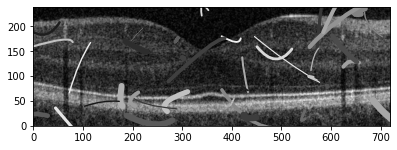

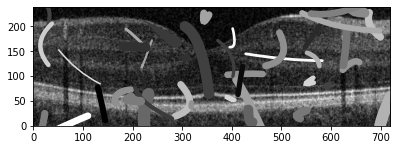

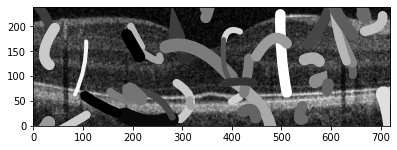

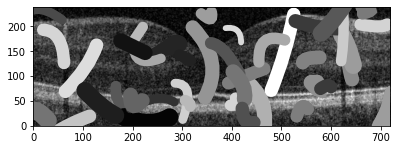

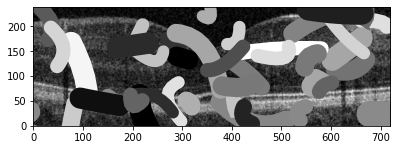

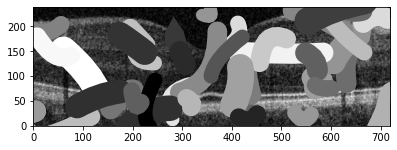

completed with  924  replacements
replacement rate =  0.4714285714285715


In [282]:
test_clew.evol_X_gens(50, 10)

# Color

In [283]:
clew = initialise_clew(40, masked_img.shape, (40, 30, 1))

In [284]:
def color_cost_single_worm(original_image, worm, key):
    masked_image = np.zeros([image.shape[0],image.shape[1]]).astype(int)
    masked_img = mask_single_worm(masked_image, worm, key)
    # masked for a particular worm (example: worm 4)
    selected_worm_mask = (masked_img == key).astype(np.uint8)
    # The selected_masked_image separates the selected worm from other worms in the old masked_image
    selected_masked_image = masked_img * selected_worm_mask[:, :] 

    # Now mask the original background for the selected worm
    orig = original_image.copy()  # Create a copy to avoid modifying the original array
    orig = orig * selected_masked_image[:,:] / key # Need to divide the worm_index because of scaling (Since the masked_image is not binary but uses numbers to index each worm)
    non_zero_masked = orig != 0
    # print(orig[non_zero_masked])
    orig[non_zero_masked] -= round(worm.colour * 255) #Find the difference between the worm and the background
    orig[~non_zero_masked] = 255
    magnitude = orig[non_zero_masked].mean()
    # print(np.absolute(orig[non_zero_masked]))
    # plt.imshow( np.absolute(orig), cmap='gray')  # Display the modified original image
    # plt.gca().invert_yaxis()
    
    return magnitude, np.absolute(orig)


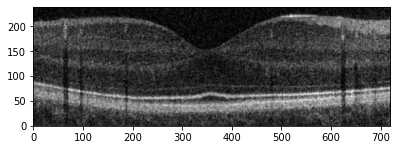

In [285]:
drawing = Drawing(original_image)
drawing.show()

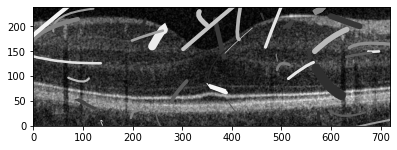

In [286]:
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

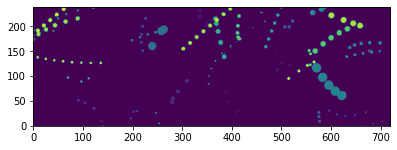

In [287]:
masked_img = mask_all_worms(original_image, clew)
plt.imshow(masked_img)
plt.gca().invert_yaxis()

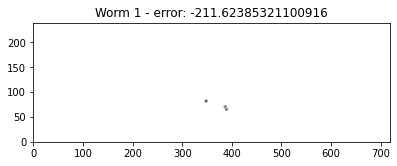

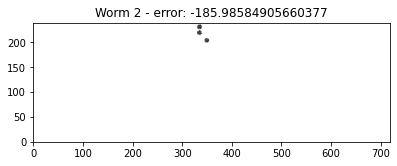

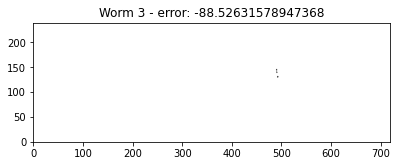

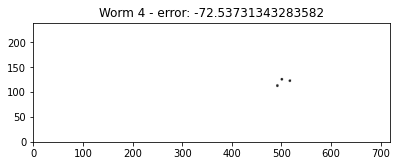

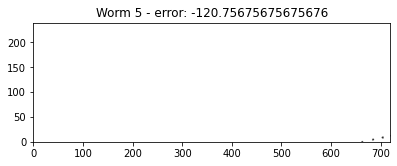

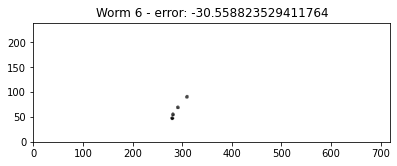

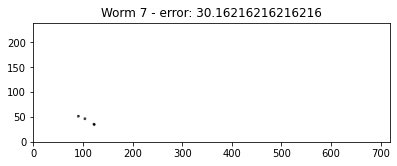

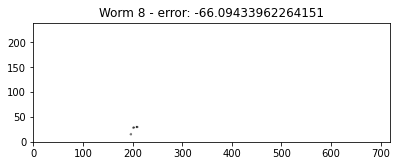

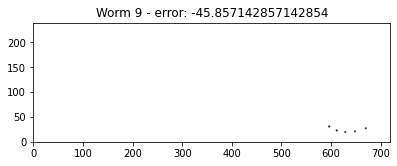

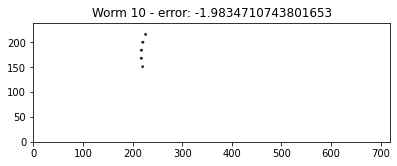

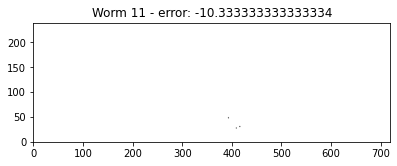

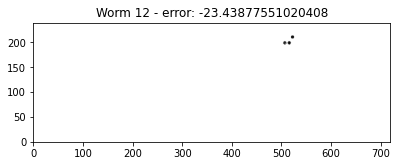

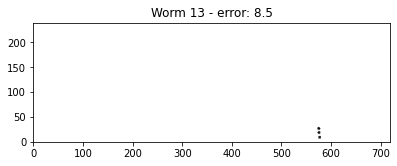

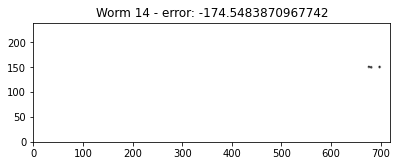

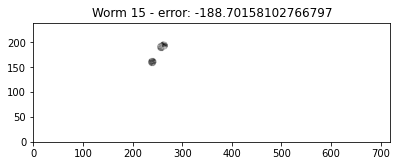

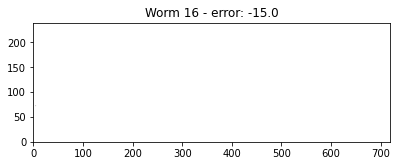

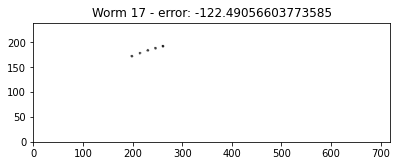

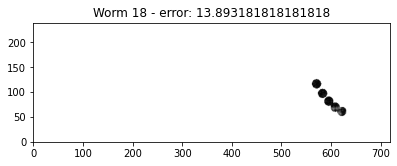

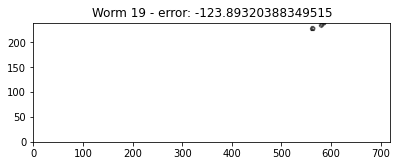

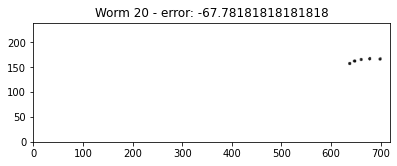

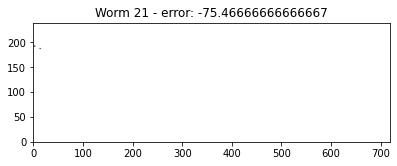

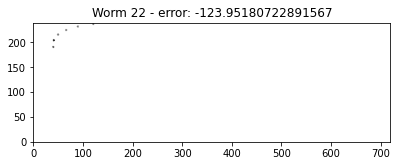

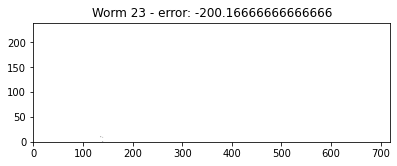

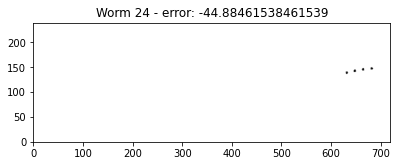

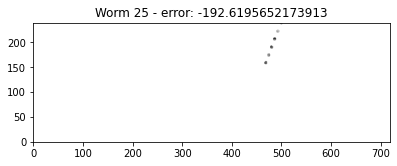

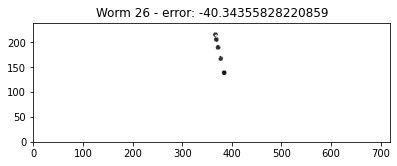

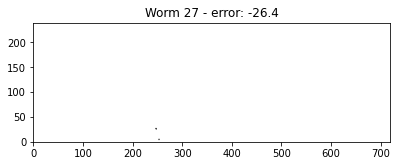

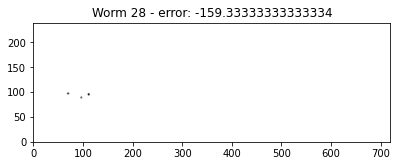

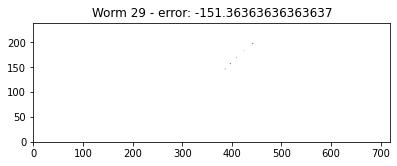

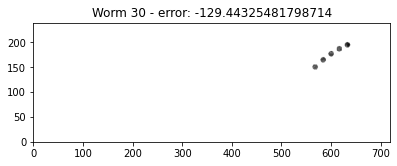

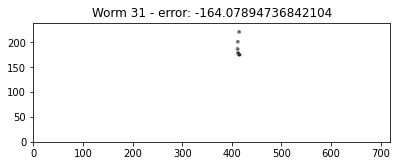

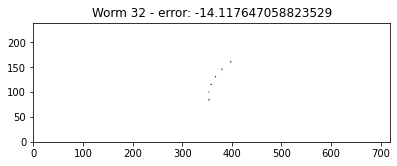

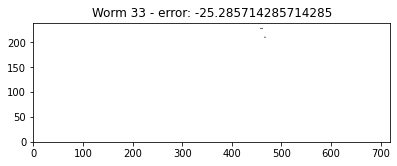

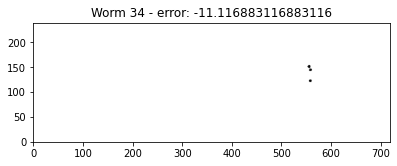

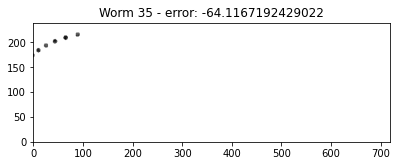

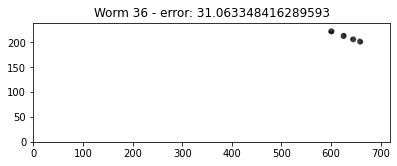

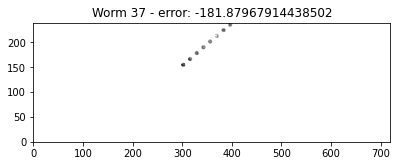

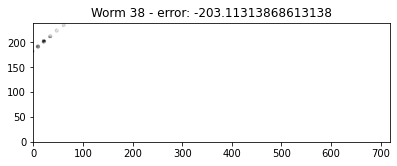

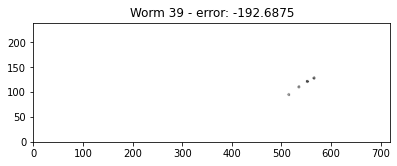

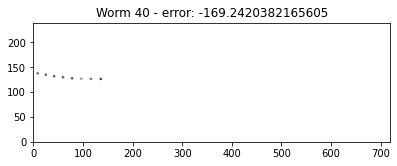

In [288]:
masked_img = np.zeros([original_image.shape[0],original_image.shape[1]]).astype(int)

for i in range(1, len(clew) + 1):
    mag, worm_img = color_cost_single_worm(original_image, clew[i-1], i)
    plt.imshow(worm_img, cmap='gray')  # Display the modified original image
    plt.gca().invert_yaxis()
    plt.title(f"Worm {i} - error: {mag}")
    plt.show()



In [289]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

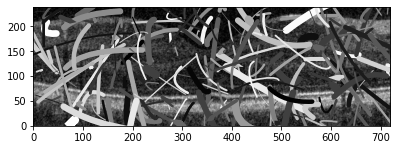

In [290]:
clew = initialise_clew(200, image.shape, (40, 30, 1))
drawing = Drawing(original_image)
drawing.add_worms(clew)
drawing.show()

In [291]:
def mutate_color():
    for j in range(100):
        for i in range(len(clew)):
            # Get the initial cost and image for the worm
            cost, img = color_cost_single_worm(original_image, clew[i], i + 1)
        
            
            # Mutate the color based on the cost
            if cost < 0:
                # If the cost is negative (indicating an improvement), move the color towards 1
                clew[i].colour = min(clew[i].colour - 0.01, 1.0)
       
            elif cost > 0:
                # If the cost is positive (indicating no improvement or worsening), move the color towards 0
                clew[i].colour = max(clew[i].colour + 0.01, 0.0)
          
            # Check if the absolute value of the cost is less than 1
            if abs(cost) < 1:
                continue  # Continue to the next worm if the cost threshold is met
        if j % 20 == 0:
            # Display the mutated worms after each iteration
            drawing = Drawing(original_image)
            drawing.add_worms(clew)
            drawing.show()


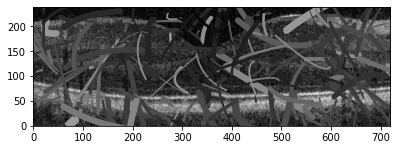

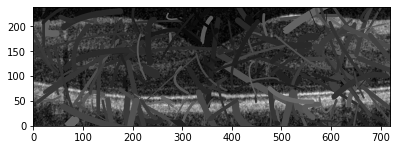

In [434]:
mutate_color()

[[704.6789073    7.16564124]
 [446.44524902 -65.33983478]
 [142.82179755 120.88681781]]


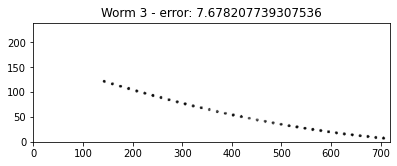

[[704.6789073    7.16564124]
 [429.16596906  33.15598485]
 [142.82179755 120.88681781]]


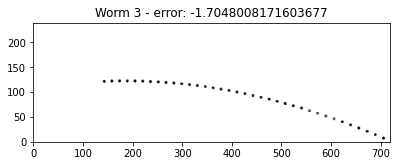

[[704.6789073    7.16564124]
 [411.88668911 131.65180448]
 [142.82179755 120.88681781]]


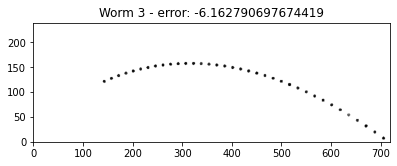

In [433]:
masked_img = np.zeros([original_image.shape[0],original_image.shape[1]]).astype(int)

for i in range(3,4):
    for j in range(3):
        sign = -1
        print(clew[i-1].control_points())
        clew[i-1].dr += (100*sign)

        clew[i-1].update_curve()

        mag, worm_img = color_cost_single_worm(original_image, clew[i-1], i)

        plt.imshow(worm_img, cmap='gray')  # Display the modified original image
        plt.gca().invert_yaxis()
        plt.title(f"Worm {i} - error: {mag}")
        plt.show()
        sign = 1

